<a href="https://colab.research.google.com/github/ayulockin/DataAugmentationTF/blob/master/Cifar_10_Evaluation_Robustness_to_Cifar_10C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setups, Installations and Imports

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [ ]:
%%capture
!pip install wandb

In [ ]:
!git clone https://github.com/ayulockin/DataAugmentationTF

Cloning into 'DataAugmentationTF'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 57 (delta 26), reused 13 (delta 2), pack-reused 0
Unpacking objects: 100% (57/57), done.


In [ ]:
%cd DataAugmentationTF/

/content/DataAugmentationTF


In [ ]:
!ls

augment_and_mix.py
augmentations.py
CIFAR_10_Baseline_Model.ipynb
Cifar_10_Evaluation_Robustness_to_Cifar_10C.ipynb
Cifar_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_AugMix_Augmentation.ipynb
CIFAR_10_with_CutMix_Augmentation.ipynb
CIFAR_10_with_Cutout_Augmentation.ipynb
CIFAR_10_with_Mixup_Augmentation.ipynb
images
models
README.md


In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.datasets import cifar10

In [ ]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

%matplotlib inline

from mpl_toolkits.axes_grid1 import ImageGrid

from PIL import Image

In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


# Download and Prepare Dataset

#### CIFAR-10

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

y_test_one_hot = pd.get_dummies(y_test.flatten()).values.astype(np.float32)

170500096/170498071 [==============================] - 2s 0us/step


In [ ]:
CLASS_NAMES = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]

In [ ]:
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 1) (10000, 32, 32, 3) (10000, 1)


#### CIFAR-10-C

In [ ]:
!mkdir -p ./data/cifar
!curl -O https://zenodo.org/record/2535967/files/CIFAR-10-C.tar
!tar -xvf CIFAR-10-C.tar -C data/cifar/                                   

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2783M  100 2783M    0     0  11.1M      0  0:04:10  0:04:10 --:--:-- 11.7M
CIFAR-10-C/
CIFAR-10-C/fog.npy
CIFAR-10-C/jpeg_compression.npy
CIFAR-10-C/zoom_blur.npy
CIFAR-10-C/speckle_noise.npy
CIFAR-10-C/glass_blur.npy
CIFAR-10-C/spatter.npy
CIFAR-10-C/shot_noise.npy
CIFAR-10-C/defocus_blur.npy
CIFAR-10-C/elastic_transform.npy
CIFAR-10-C/gaussian_blur.npy
CIFAR-10-C/frost.npy
CIFAR-10-C/saturate.npy
CIFAR-10-C/brightness.npy
CIFAR-10-C/snow.npy
CIFAR-10-C/gaussian_noise.npy
CIFAR-10-C/motion_blur.npy
CIFAR-10-C/contrast.npy
CIFAR-10-C/impulse_noise.npy
CIFAR-10-C/labels.npy
CIFAR-10-C/pixelate.npy


# Prepare CIFAR-10-C

In [ ]:
datapath = "data/cifar/CIFAR-10-C/"

corruptions = os.listdir(datapath)
count = 0
for corruption in corruptions:
  if 'labels' in corruption:
    continue
  # print(corruption)
  count+=1

print('Total corruptions: ', count)

Total corruptions:  19


In [ ]:
## Load corrupted images on memory
corrupted_images = {}

for corruption in corruptions:
  if 'labels' in corruption:
    labels = np.load(datapath+corruption)
    continue

  corruption_type = corruption.split('.')[0]
  print('Corruption type: ', corruption_type)

  imgs = np.load(datapath+corruption)
  corrupted_images[corruption_type] = imgs

Corruption type:  gaussian_blur
Corruption type:  zoom_blur
Corruption type:  frost
Corruption type:  contrast
Corruption type:  pixelate
Corruption type:  fog
Corruption type:  spatter
Corruption type:  brightness
Corruption type:  shot_noise
Corruption type:  gaussian_noise
Corruption type:  speckle_noise
Corruption type:  glass_blur
Corruption type:  elastic_transform
Corruption type:  impulse_noise
Corruption type:  saturate
Corruption type:  snow
Corruption type:  defocus_blur
Corruption type:  jpeg_compression
Corruption type:  motion_blur


#### Visualize

In [ ]:
## Visualize
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,38))
  for n in range(95):
      ax = plt.subplot(19, 5, n+1)
      plt.imshow(image_batch[n])
      
      plt.axis('off')

In [ ]:
## Load samples images 
sample_images = []
sample_corruption = []

label_idx = 1
sample_label = labels[label_idx]

for corruption_type, images in corrupted_images.items():
  start = label_idx
  sample_corruption.append(corruption_type)
  for j in range(5):
    sample_images.append(images[start])
    start+=10000

print('Total corrupted images: {} and it\'s label: {}'.format(len(sample_images), CLASS_NAMES[sample_label]))

Total corrupted images: 95 and it's label: ship


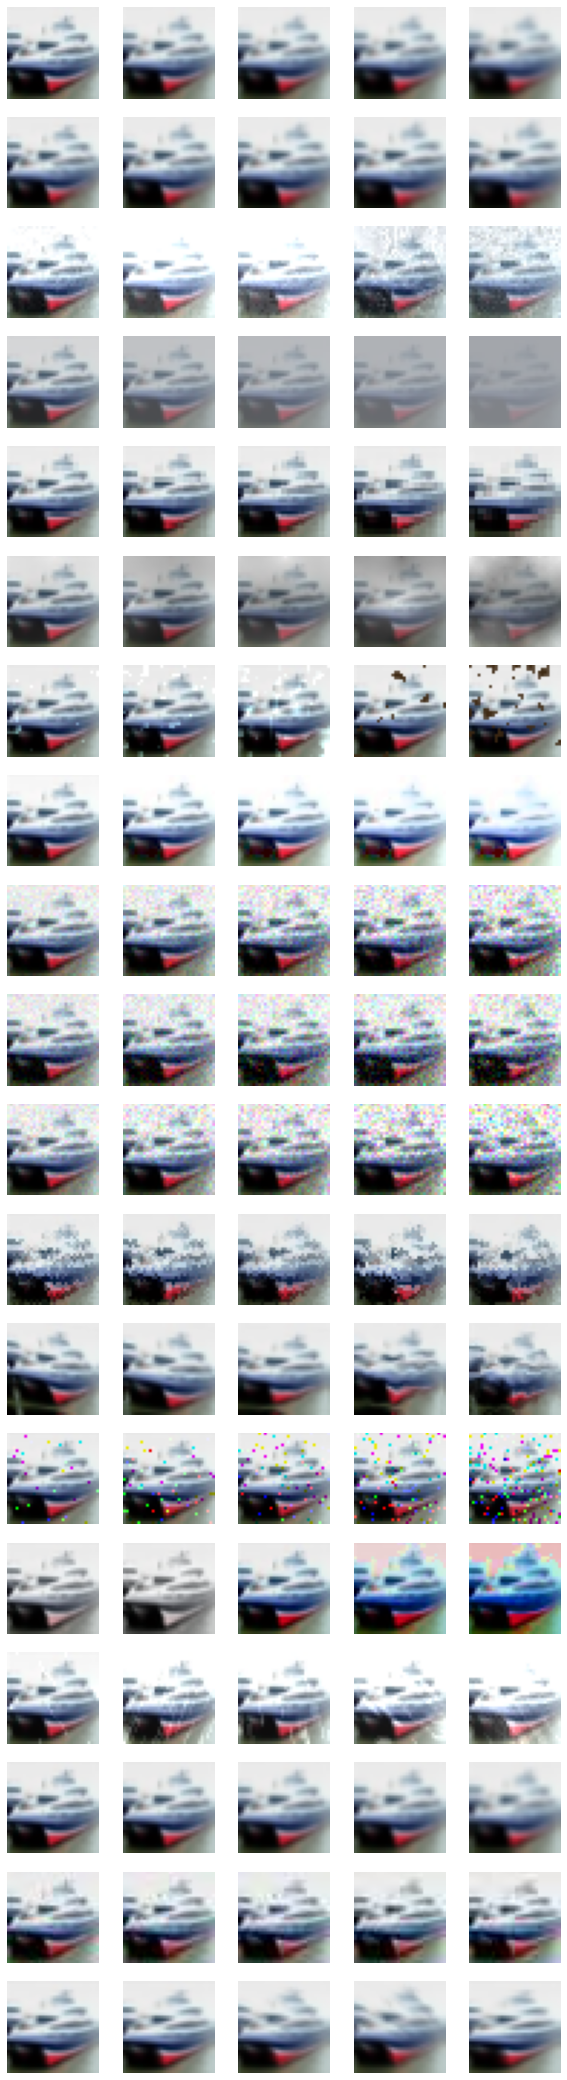

In [ ]:
show_batch(sample_images, sample_label)

# Get Model Weights

In [ ]:
%cd ../../

/


In [ ]:
!ls

bin					   etc	   mnt	 swift
boot					   gdrive  opt	 sys
content					   home    proc  tensorflow-1.15.2
datalab					   lib	   root  tmp
dev					   lib32   run	 tools
dlib-19.18.0-cp27-cp27mu-linux_x86_64.whl  lib64   sbin  usr
dlib-19.18.0-cp36-cp36m-linux_x86_64.whl   media   srv	 var


In [ ]:
%mkdir content/DataAugmentationTF/model_weights/

In [ ]:
%cp -r gdrive/My\ Drive/DataAugmentation content/DataAugmentationTF/model_weights/

In [ ]:
%cd content/DataAugmentationTF/

/content/DataAugmentationTF


# Get Model 

In [ ]:
from models.resnet import resnet_v1

In [ ]:
def Model():
  return resnet_v1((32,32,3), 20)

# Model Weight Paths

In [ ]:
ROOT_WT_PATH = 'model_weights/DataAugmentation/'

In [ ]:
baseline = ROOT_WT_PATH+'baseline.h5' ## baseline model
cutout = ROOT_WT_PATH+'model_cutout_12.h5' ## best model from ablation study
mixup = ROOT_WT_PATH+'model_mixup_5.h5' ## best model from ablation study
cutmix = ROOT_WT_PATH+'model_cutmix_0.h5' ## best model from ablation study

In [ ]:
## model trained with augmix was saved in .ckpt format
checkpoint_dir = ROOT_WT_PATH+'model_checkpoints'

In [ ]:
MODELS = [baseline, cutout, mixup, cutmix, 'augmix']

# Evaluate on Cifar-10 Test Dataset

#### Data Loader

In [ ]:
def preprocess_image(image, label):
  image = tf.image.resize(image, (IMG_SHAPE, IMG_SHAPE))
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = image/255.
  return image, label

In [ ]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMG_SHAPE = 32

testloader = tf.data.Dataset.from_tensor_slices((x_test, y_test))
testloader = (
    testloader
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader_one_hot = tf.data.Dataset.from_tensor_slices((x_test, y_test_one_hot))
testloader_one_hot = (
    testloader_one_hot
    .map(preprocess_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

#### Eval

In [ ]:
wandb.init(entity='authors', project='tfaugmentation')

W&B Run: https://app.wandb.ai/authors/tfaugmentation/runs/30xnoyrw

In [ ]:
one_hot_model = [mixup, cutmix]
augnames = ['baseline', 'cutout', 'mixup', 'cutmix', 'augmix']

for c, model_wts in enumerate(MODELS):
  wandb.init(entity='authors', project='tfaugmentation')

  aug_name = augnames[c]
  
  keras.backend.clear_session()
  model = Model()
  if model_wts is not 'augmix':
    model.load_weights(model_wts)

  if model_wts in one_hot_model:
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])  
    loss, accuracy = model.evaluate(testloader_one_hot, verbose=0)

  elif model_wts is 'augmix':
    optim = keras.optimizers.Adam(learning_rate=0.001) 

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optim, model=model)

    checkpoint_manager = tf.train.CheckpointManager(checkpoint, 
                                                    directory=checkpoint_dir,
                                                    max_to_keep=1)

    # check for previous checkpoints, if any
    checkpoint.restore(checkpoint_manager.latest_checkpoint)    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])  
    loss, accuracy = model.evaluate(testloader_one_hot, verbose=0)

  else:
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
    loss, accuracy = model.evaluate(testloader, verbose=0)
  
  print('Augmentation: {} | Test Error Rate: {}'.format(aug_name, round((1-accuracy)*100,2)))
  wandb.log({'test error rate': round((1-accuracy)*100,2)})

Augmentation: baseline | Test Error Rate: 24.31


Augmentation: cutout | Test Error Rate: 19.51


Augmentation: mixup | Test Error Rate: 16.92


Augmentation: cutmix | Test Error Rate: 16.09


Augmentation: augmix | Test Error Rate: 14.42


# Evaluate on Cifar-10-C 

In [ ]:
CORRUPTIONS = [
    'gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur',
    'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog',
    'brightness', 'contrast', 'elastic_transform', 'pixelate',
    'jpeg_compression'
]

In [ ]:
def evaluate_cifar_c(y_labels, model):
  datapath = "data/cifar/CIFAR-10-C/"
  corruptlist = os.listdir(datapath)

  corruption_error = {}
  corruption_avg_error = []

  # Initialize wandb table 
  table = wandb.Table(columns=["Corruption Type", "L1", "L2", "L3", "L4", "L5"])
  # iterate over corrupted images one corruption at a time
  for corruption in corruptlist:
    corruption_type = corruption.split('.')[0]
    corruption_error[corruption_type] = []

    if corruption_type in CORRUPTIONS:
      c_imgs = np.load(datapath+corruption)

      for level in range(5):
        c_testloader = tf.data.Dataset.from_tensor_slices((c_imgs[level*10000:(level+1)*10000], y_labels))
        c_testloader = (
            c_testloader
            .map(preprocess_image, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )

        c_loss, c_acc = model.evaluate(c_testloader, verbose=0)
        corruption_error[corruption_type].append(round((1-c_acc)*100,2))

      print("Corruption type: ", corruption_type)
      
      c_sum = 0
      for count, error in enumerate(corruption_error[corruption_type]):
        c_sum+=error
        print('Test error rate for severity {} is {}'.format(count+1, error))

      avg_c_error = c_sum/5

      errors = corruption_error[corruption_type]
      table.add_data(corruption_type, errors[0], errors[1], errors[2], errors[3], errors[4])

      corruption_avg_error.append(avg_c_error)
      print('*'*70)
  
  # log table
  wandb.log({"examples": table})
  
  # return average corruption error rate 
  return np.mean(corruption_avg_error)

In [ ]:
one_hot_model = [mixup, cutmix]
augnames = ['baseline', 'cutout', 'mixup', 'cutmix', 'augmix']

test_error_rate_corrupt = []

for c, model_wts in enumerate(MODELS):
  wandb.init(entity='authors', project='tfaugmentation')
  aug_name = augnames[c]

  print('Augmentation: ', aug_name)
  keras.backend.clear_session()
  model = Model()
  if model_wts is not 'augmix':
    model.load_weights(model_wts)

  if model_wts in one_hot_model:
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    error = evaluate_cifar_c(y_test_one_hot, model)
    wandb.log({'corruption error rate': error})  
    test_error_rate_corrupt.append(error)

  elif model_wts is 'augmix':
    optim = keras.optimizers.Adam(learning_rate=0.001) 

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optim, model=model)

    checkpoint_manager = tf.train.CheckpointManager(checkpoint, 
                                                    directory=checkpoint_dir,
                                                    max_to_keep=1)

    # check for previous checkpoints, if any
    checkpoint.restore(checkpoint_manager.latest_checkpoint)    
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])  

    error = evaluate_cifar_c(y_test_one_hot, model)
    wandb.log({'corruption error rate': error})  
    test_error_rate_corrupt.append(error)

  else:
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
    error = evaluate_cifar_c(y_test, model)
    wandb.log({'corruption error rate': error})  
    test_error_rate_corrupt.append(error)
  print('-'*90)

Augmentation:  baseline
Corruption type:  zoom_blur
Test error rate for severity 1 is 32.58
Test error rate for severity 2 is 34.26
Test error rate for severity 3 is 37.36
Test error rate for severity 4 is 40.42
Test error rate for severity 5 is 44.67
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 27.26
Test error rate for severity 2 is 31.23
Test error rate for severity 3 is 38.21
Test error rate for severity 4 is 39.42
Test error rate for severity 5 is 45.79
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 24.91
Test error rate for severity 2 is 32.92
Test error rate for severity 3 is 41.52
Test error rate for severity 4 is 55.63
Test error rate for severity 5 is 76.39
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 28.52
Test error rate f

Augmentation:  cutout
Corruption type:  zoom_blur
Test error rate for severity 1 is 27.97
Test error rate for severity 2 is 31.41
Test error rate for severity 3 is 36.31
Test error rate for severity 4 is 41.15
Test error rate for severity 5 is 48.33
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 25.51
Test error rate for severity 2 is 33.34
Test error rate for severity 3 is 44.82
Test error rate for severity 4 is 47.04
Test error rate for severity 5 is 58.18
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 20.84
Test error rate for severity 2 is 28.14
Test error rate for severity 3 is 36.02
Test error rate for severity 4 is 50.29
Test error rate for severity 5 is 74.41
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 21.7
Test error rate for 

Augmentation:  mixup
Corruption type:  zoom_blur
Test error rate for severity 1 is 32.83
Test error rate for severity 2 is 37.71
Test error rate for severity 3 is 43.88
Test error rate for severity 4 is 48.96
Test error rate for severity 5 is 55.31
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 20.16
Test error rate for severity 2 is 24.16
Test error rate for severity 3 is 30.42
Test error rate for severity 4 is 32.52
Test error rate for severity 5 is 39.33
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 18.43
Test error rate for severity 2 is 25.09
Test error rate for severity 3 is 32.23
Test error rate for severity 4 is 46.29
Test error rate for severity 5 is 77.33
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 19.53
Test error rate for 

Augmentation:  cutmix
Corruption type:  zoom_blur
Test error rate for severity 1 is 27.7
Test error rate for severity 2 is 32.4
Test error rate for severity 3 is 39.07
Test error rate for severity 4 is 45.39
Test error rate for severity 5 is 53.68
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 24.08
Test error rate for severity 2 is 31.99
Test error rate for severity 3 is 43.02
Test error rate for severity 4 is 44.57
Test error rate for severity 5 is 54.27
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 17.72
Test error rate for severity 2 is 26.31
Test error rate for severity 3 is 34.06
Test error rate for severity 4 is 48.62
Test error rate for severity 5 is 80.47
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 19.61
Test error rate for s

Augmentation:  augmix
Corruption type:  zoom_blur
Test error rate for severity 1 is 17.28
Test error rate for severity 2 is 18.02
Test error rate for severity 3 is 19.47
Test error rate for severity 4 is 21.31
Test error rate for severity 5 is 24.94
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 16.2
Test error rate for severity 2 is 18.41
Test error rate for severity 3 is 22.6
Test error rate for severity 4 is 23.95
Test error rate for severity 5 is 28.66
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 14.43
Test error rate for severity 2 is 16.27
Test error rate for severity 3 is 18.46
Test error rate for severity 4 is 22.78
Test error rate for severity 5 is 46.67
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 15.75
Test error rate for s

In [ ]:
test_error_rate_corrupt

[39.05426666666666, 40.8688, 37.60013333333333, 40.382, 24.927200000000006]

<BarContainer object of 5 artists>

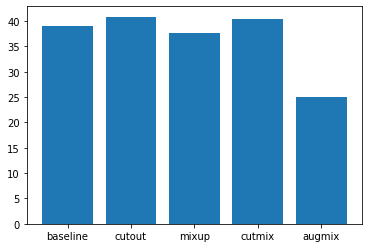

In [ ]:
augs = ['baseline', 'cutout', 'mixup', 'cutmix', 'augmix']
plt.bar(augs, test_error_rate_corrupt)

In [ ]:
MODELS = [baseline, 'augmix']

In [ ]:
def evaluate_cifar_c(y_labels, model):
  datapath = "data/cifar/CIFAR-10-C/"
  corruptlist = os.listdir(datapath)

  corruption_error = {}
  corruption_avg_error = []
  corruption_avg = {}


  # iterate over corrupted images one corruption at a time
  for corruption in corruptlist:
    corruption_type = corruption.split('.')[0]
    corruption_error[corruption_type] = []

    if corruption_type in CORRUPTIONS:
      c_imgs = np.load(datapath+corruption)

      for level in range(5):
        c_testloader = tf.data.Dataset.from_tensor_slices((c_imgs[level*10000:(level+1)*10000], y_labels))
        c_testloader = (
            c_testloader
            .map(preprocess_image, num_parallel_calls=AUTO)
            .batch(BATCH_SIZE)
            .prefetch(AUTO)
        )

        c_loss, c_acc = model.evaluate(c_testloader, verbose=0)
        corruption_error[corruption_type].append(round((1-c_acc)*100,2))

      print("Corruption type: ", corruption_type)
      
      c_sum = 0
      for count, error in enumerate(corruption_error[corruption_type]):
        c_sum+=error
        print('Test error rate for severity {} is {}'.format(count+1, error))

      
      avg_c_error = c_sum/5
    
      corruption_avg_error.append(avg_c_error)
      corruption_avg[corruption_type] = avg_c_error
      print('*'*70)
  
  # return average corruption error rate 
  return np.mean(corruption_avg_error), corruption_avg

In [ ]:
one_hot_model = [mixup, cutmix]
augnames = ['baseline', 'augmix']

test_error_rate_corrupt = []
corruption_errors = []

for c, model_wts in enumerate(MODELS):
  aug_name = augnames[c]

  print('Augmentation: ', aug_name)
  keras.backend.clear_session()
  model = Model()
  if model_wts is not 'augmix':
    model.load_weights(model_wts)

  if model_wts in one_hot_model:
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])
    error, corruption_error = evaluate_cifar_c(y_test_one_hot, model)
    corruption_errors.append(corruption_error)
    test_error_rate_corrupt.append(error)

  elif model_wts is 'augmix':
    optim = keras.optimizers.Adam(learning_rate=0.001)

    checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
    checkpoint = tf.train.Checkpoint(optimizer=optim, model=model)

    checkpoint_manager = tf.train.CheckpointManager(checkpoint, 
                                                    directory=checkpoint_dir,
                                                    max_to_keep=1)

    # check for previous checkpoints, if any
    checkpoint.restore(checkpoint_manager.latest_checkpoint)
    model.compile('adam', 'categorical_crossentropy', metrics=['acc'])

    error, corruption_error = evaluate_cifar_c(y_test_one_hot, model)
    corruption_errors.append(corruption_error)
    test_error_rate_corrupt.append(error)

  else:
    model.compile('adam', 'sparse_categorical_crossentropy', metrics=['acc'])
    error, corruption_error = evaluate_cifar_c(y_test, model)
    corruption_errors.append(corruption_error)
    test_error_rate_corrupt.append(error)

  print('-'*90)

Augmentation:  baseline
Corruption type:  zoom_blur
Test error rate for severity 1 is 32.58
Test error rate for severity 2 is 34.26
Test error rate for severity 3 is 37.36
Test error rate for severity 4 is 40.42
Test error rate for severity 5 is 44.67
**********************************************************************
Corruption type:  frost
Test error rate for severity 1 is 27.26
Test error rate for severity 2 is 31.23
Test error rate for severity 3 is 38.21
Test error rate for severity 4 is 39.42
Test error rate for severity 5 is 45.79
**********************************************************************
Corruption type:  contrast
Test error rate for severity 1 is 24.91
Test error rate for severity 2 is 32.92
Test error rate for severity 3 is 41.52
Test error rate for severity 4 is 55.63
Test error rate for severity 5 is 76.39
**********************************************************************
Corruption type:  pixelate
Test error rate for severity 1 is 28.52
Test error rate f

In [ ]:
baseline_corruption, augmix_corruption = corruption_errors

In [ ]:
baseline_errors = list(baseline_corruption.values())
augmix_errors = list(augmix_corruption.values())

In [ ]:
wandb.init(entity='authors', project='tfaugmentation')

corruption_names = list(baseline_corruption.keys())
width = 0.35

x = np.arange(len(corruption_names))

plt.figure(figsize=(16, 8))

plt.bar(x-width/2, baseline_errors, width)
plt.bar(x+width/2, augmix_errors, width)

plt.ylabel('corruption error rate %')
plt.xticks(x, corruption_names)

wandb.log({'baseline_vs_augmix': plt})

/usr/local/lib/python3.6/dist-packages/plotly/matplotlylib/mpltools.py:368: MatplotlibDeprecationWarning:


The is_frame_like function was deprecated in Matplotlib 3.1 and will be removed in 3.3.



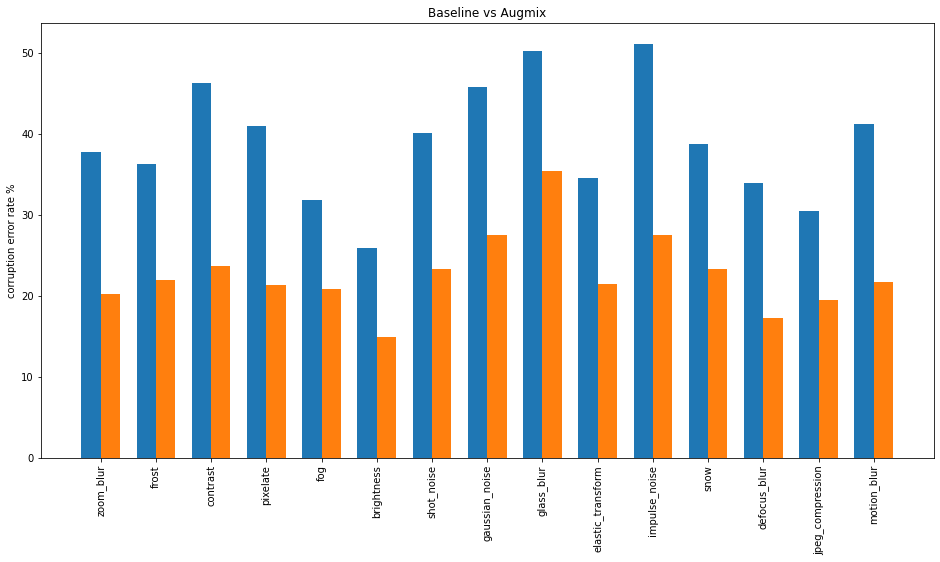

In [ ]:

corruption_names = list(baseline_corruption.keys())
width = 0.35

x = np.arange(len(corruption_names))

plt.figure(figsize=(16, 8))

plt.bar(x-width/2, baseline_errors, width);
plt.bar(x+width/2, augmix_errors, width);

plt.ylabel('corruption error rate %');
plt.title('Baseline vs Augmix')
plt.xticks(x, corruption_names, rotation='vertical');
